In [ ]:
pip install miditoolkit miditok numpy pandas torch tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from symusic import Score
from miditok import REMI, TokenizerConfig
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
def get_remi_tokenizer():
    config = TokenizerConfig(
        use_programs=True,
        use_chords=False,
        use_rests=True,
        use_tempos=False,
        use_time_signatures=False,
        add_special_tokens=True,
        num_velocities=32,
        pitch_range=(21, 108),
        beat_res={(0, 4): 8},
        num_tempos=32,
        tempo_range=(40, 250),
    )
    tokenizer = REMI(config)
    tokenizer.save("remi_tokenizer_config.json")
    return tokenizer


In [ ]:
DATA_DIR = Path("/Users/jerol/Desktop/music_data_piano")
GENRES = {"classical": 0, "jazz": 1}
SAVE_PATH = Path("tokenized_data.pt")

def tokenize_dataset(data_dir: Path, genres: dict, tokenizer: REMI):
    dataset = []

    for genre, style_id in genres.items():
        genre_path = data_dir / genre
        for artist_folder in genre_path.iterdir():
            if not artist_folder.is_dir():
                continue
            for ext in ("*.mid", "*.midi"):
                for midi_file in artist_folder.rglob(ext):
                    try:
                        score = Score(midi_file)
                        tokens = tokenizer(score)
                        token_ids = tokens.ids
                        if len(token_ids) > 0:
                            dataset.append({"tokens": token_ids, "style": style_id})
                    except Exception as e:
                        print(f"Could not process {midi_file}: {e}")
    return dataset

# run tokenizer on dataset
tokenizer = get_remi_tokenizer()
dataset = tokenize_dataset(DATA_DIR, GENRES, tokenizer)

print(f"Tokenized {len(dataset)} samples")

torch.save(dataset, SAVE_PATH)


In [ ]:
tokenizer = REMI(params="remi_tokenizer_config.json")

In [ ]:
def get_special_tokens(tokenizer):
      pad_id = tokenizer.vocab["PAD_None"] # special tokens used by miditok
      bos_id = tokenizer.vocab["BOS_None"]
      eos_id = tokenizer.vocab["EOS_None"]

    return pad_id, bos_id, eos_id

class MIDIDataset(Dataset):
    def __init__(self, samples, tokenizer, seq_length=512):
        self.data = []
        self.pad_id, self.bos_id, self.eos_id = get_special_tokens(tokenizer)
        self.seq_length = seq_length

        for sample in samples:
            seq = sample["tokens"]
            label = sample["style"]

            # add bos and eos tokens
            seq = [self.bos_id] + seq + [self.eos_id]

            # pad or trunc to 512
            if len(seq) < self.seq_length:
                seq += [self.pad_id] * (self.seq_length - len(seq))
            else:
                seq = seq[:self.seq_length]

            self.data.append((seq, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, label = self.data[idx]
        input_ids = torch.LongTensor(seq[:-1])  # input
        target_ids = torch.LongTensor(seq[1:])  # shifted target
        return {
            "input_ids": input_ids,
            "target_ids": target_ids,
            "genre": torch.tensor(label, dtype=torch.long),
        }


def build_dataloaders(pt_dataset_path, tokenizer, batch_size=16, seq_length=512):
    raw_data = torch.load(pt_dataset_path)  # list of {tokens, genre}

    labels = [d["style"] for d in raw_data]

     # 90% train, 10% test
    train_data, test_data = train_test_split(raw_data, test_size=0.1, stratify=labels, random_state=33)

    train_dataset = MIDIDataset(train_data, tokenizer, seq_length)
    test_dataset = MIDIDataset(test_data, tokenizer, seq_length)

    return {
        "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        "test": DataLoader(test_dataset, batch_size=batch_size),
    }


In [ ]:
dataloaders = build_dataloaders("tokenized_data.pt", tokenizer, batch_size=16, seq_length=512)

for batch in dataloaders["train"]:
    print(batch["input_ids"].shape)
    print(batch["target_ids"].shape)
    print(batch["genre"])
    break

In [ ]:
for token_str, token_id in tokenizer.vocab.items():
    if "BOS" in token_str or "EOS" in token_str or "PAD" in token_str:
        print (f"{token_str} -> {token_id}")

PAD_None -> 0
BOS_None -> 1
EOS_None -> 2


In [ ]:
vocab_size = tokenizer.vocab_size
bos_id = tokenizer.vocab["BOS_None"]
pad_id = tokenizer.vocab["PAD_None"]
eos_id = tokenizer.vocab["EOS_None"]

In [ ]:
train_loader = dataloaders["train"]
test_loader = dataloaders["test"]


In [ ]:
class MST_VAE(nn.Module):
    def __init__(self,
                 vocab_size,
                 emb_dim=256,
                 hidden_dim=512,
                 latent_dim=64,
                 genre_emb_dim=16,
                 num_genres=2,
                 seq_length=512,
                 bos_token_id=None,
                 dropout=0.3):
        super().__init__()

        self.seq_length=seq_length
        self.bos_token_id=bos_token_id
        self.latent_dim=latent_dim
        self.embedding=nn.Embedding(vocab_size, emb_dim)
        self.embedding_dropout=nn.Dropout(dropout)

        self.encoder = nn.LSTM(
            emb_dim,
            hidden_dim,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )

        self.fc_mu = nn.Linear(2 * hidden_dim, latent_dim)
        nn.init.normal_(self.fc_mu.bias, mean=0.0, std=0.1) # start values

        self.fc_logvar = nn.Linear(2 * hidden_dim, latent_dim)
        self.fc_logvar.bias.data.fill_(-1.0) # start values

        self.genre_embedding = nn.Embedding(num_genres, genre_emb_dim)
        self.latent_to_hidden = nn.Linear(latent_dim + genre_emb_dim, hidden_dim)

        self.decoder_lstm=nn.LSTM(
            emb_dim + latent_dim + genre_emb_dim,
            hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )

        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def encode(self, x):
        embedded = self.embedding_dropout(self.embedding(x))
        _, (hidden, _) = self.encoder(embedded)

        num_layers = self.encoder.num_layers

        h_forward = hidden[2 * (num_layers - 1)]
        h_backward = hidden[2 * (num_layers - 1) + 1]
        h_final = torch.cat([h_forward, h_backward], dim=1)

        mu = self.fc_mu(h_final)
        logvar = self.fc_logvar(h_final)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std=torch.exp(0.5 * logvar)
        eps=torch.randn_like(std)
        return mu + eps * std

    def decode(self, z_c, genre, target_seq=None, tfratio=1.0):
        batch_size=z_c.size(0)
        seq_len=target_seq.size(1) if target_seq is not None else self.seq_length

        z_s = self.genre_embedding(genre)
        z_cond = torch.cat([z_c, z_s], dim=-1)

        h_0 = torch.tanh(self.latent_to_hidden(z_cond)).unsqueeze(0) # tanh for stability
        h_0 = h_0.repeat(self.decoder_lstm.num_layers, 1, 1)
        c_0 = torch.zeros_like(h_0)

        input_token = torch.full((batch_size, 1),
                                 self.bos_token_id,
                                 dtype=torch.long,
                                 device=z_c.device)

        outputs = []

        for t in range(seq_len):
            embedded = self.embedding_dropout(self.embedding(input_token))
            z_c_step = z_c.unsqueeze(1)
            z_s_step = z_s.unsqueeze(1)

            lstm_input = torch.cat([embedded, z_c_step, z_s_step], dim=-1)

            output, (h_0, c_0) = self.decoder_lstm(lstm_input, (h_0, c_0))
            logits = self.fc_out(output.squeeze(1))

            outputs.append(logits.unsqueeze(1))

            if target_seq is not None and torch.rand(1).item() < tfratio and t > 0:
                input_token = target_seq[:, t].unsqueeze(1)
            else:
                input_token = logits.argmax(dim=-1).unsqueeze(1)

        return torch.cat(outputs, dim=1)

    def forward(self, input_ids, target_ids, genre, tfratio=1.0): # always using teacher forcing
        mu, logvar = self.encode(input_ids)
        z_c = self.reparameterize(mu, logvar)
        recon_logits = self.decode(z_c, genre, target_ids, tfratio)

        return recon_logits, mu, logvar


In [ ]:
def kl_anneal(epoch, max_beta=0.00075, anneal_epochs=10):
    return min(max_beta, max_beta * (epoch/anneal_epochs))

def train(model,
          dataloader,
          optimizer,
          epoch,
          pad_id,
          device="cuda",
          max_beta=1.0,
          anneal_epochs=10,
          clip=1.0,
          free_bits=0.005):

    model.train()

    total_loss=0
    total_recon=0
    total_kl=0
    total_correct=0
    total_tokens=0

    latent_dim=model.latent_dim

    beta = kl_anneal(epoch, max_beta, anneal_epochs)

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        target_ids = batch["target_ids"].to(device)
        genre = batch["genre"].to(device)

        optimizer.zero_grad()
        recon_logits, mu, logvar = model(input_ids, target_ids, genre)

        mask = (target_ids != pad_id) # mask for padding
        total_token_count = mask.sum().item()

        recon_loss = F.cross_entropy(
            recon_logits.view(-1, recon_logits.size(-1)),
            target_ids.view(-1),
            ignore_index=pad_id,
            reduction="none"
        )
        recon_loss=recon_loss.sum() / total_token_count

        kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kl_per_dim = torch.clamp(kl_per_dim, min=free_bits)
        kl_loss = kl_per_dim.sum(dim=-1).mean()

        loss = recon_loss + beta * kl_loss # total loss

        loss.backward()

        if clip:
            nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        with torch.no_grad():
            preds = recon_logits.argmax(dim=-1)
            correct = (preds == target_ids) & mask

            total_correct += correct.sum().item()
            total_tokens += total_token_count
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()

    acc = 100.0 * total_correct / total_tokens
    avg_loss = total_loss / len(dataloader)
    avg_recon = total_recon / len(dataloader)
    avg_kl = total_kl / len(dataloader)

    print(
        f"[Epoch {epoch:02d}] "
        f"Loss: {avg_loss:.4f} | "
        f"Recon: {avg_recon:.4f} | "
        f"KL: {avg_kl:.4f} | "
        f"Token Acc: {acc:.2f}% | "
        f"β = {beta:.4f} | "
        f"μ = {mu.mean().item():.4f} | logvar = {logvar.mean().item():.4f}"
    )

    return {
        "loss": avg_loss,
        "recon": avg_recon,
        "kl": avg_kl,
        "acc": acc,
        "beta": beta
    }


In [ ]:
pad_id, bos_id, eos_id = get_special_tokens(tokenizer)

num_styles = len(GENRES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MST_VAE(vocab_size=len(tokenizer.vocab), bos_token_id=bos_id).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
beta=0.001

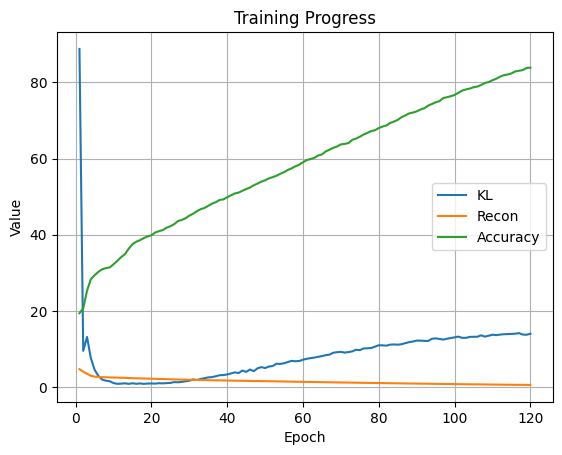

In [ ]:
epochs = range(1, len(history) + 1)
plt.plot(epochs, [m["kl"] for m in history], label="KL")
plt.plot(epochs, [m["recon"] for m in history], label="Recon")
plt.plot(epochs, [m["acc"] for m in history], label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
history = []
num_epochs=120

for epoch in range(1, num_epochs + 1):
    epoch_metrics = train(model,
                          train_loader,
                          optimizer,
                          epoch,
                          pad_id=pad_id,
                          device=device,
                          max_beta=0.00075,
                          anneal_epochs=20)
    history.append(epoch_metrics)


[Epoch 01] Loss: 4.6637 | Recon: 4.6603 | KL: 88.8158 | Token Acc: 19.37% | β = 0.0150 | μ = 0.1613 | logvar = -0.5854
[Epoch 02] Loss: 4.0019 | Recon: 4.0012 | KL: 9.4728 | Token Acc: 20.64% | β = 0.0300 | μ = -0.0053 | logvar = -0.7469
[Epoch 03] Loss: 3.4417 | Recon: 3.4403 | KL: 13.1383 | Token Acc: 25.28% | β = 0.0450 | μ = -0.0745 | logvar = -0.5107
[Epoch 04] Loss: 2.9310 | Recon: 2.9298 | KL: 7.5953 | Token Acc: 28.28% | β = 0.0600 | μ = -0.0113 | logvar = -0.2980
[Epoch 05] Loss: 2.6948 | Recon: 2.6939 | KL: 4.5019 | Token Acc: 29.34% | β = 0.0750 | μ = 0.0017 | logvar = -0.2939
[Epoch 06] Loss: 2.6049 | Recon: 2.6043 | KL: 2.8840 | Token Acc: 30.24% | β = 0.0900 | μ = 0.0159 | logvar = -0.1720
[Epoch 07] Loss: 2.5610 | Recon: 2.5605 | KL: 1.9206 | Token Acc: 30.92% | β = 0.1050 | μ = -0.0151 | logvar = -0.1776
[Epoch 08] Loss: 2.5359 | Recon: 2.5354 | KL: 1.6348 | Token Acc: 31.23% | β = 0.1200 | μ = 0.0077 | logvar = -0.1213
[Epoch 09] Loss: 2.5014 | Recon: 2.5009 | KL: 1.48

In [ ]:
# test loader

history = []
num_epochs=1

for epoch in range(1, num_epochs + 1):
    epoch_metrics = train(model,
                          test_loader,
                          optimizer,
                          epoch,
                          pad_id=pad_id,
                          device=device,
                          max_beta=0.00075,
                          anneal_epochs=1)
    history.append(epoch_metrics)

[Epoch 01] Loss: 2.7388 | Recon: 2.7292 | KL: 12.8339 | Token Acc: 42.94% | β = 0.0008 | μ = 0.0088 | logvar = -0.8468


In [ ]:
def sample_next_token(logits, temperature=1.0, top_k=1):
    if top_k > 0:
        top_k = min(top_k, logits.size(-1))
        top_logits, top_indices = torch.topk(logits, top_k)

        probs = F.softmax(top_logits, dim=-1)
        idx = torch.multinomial(probs, num_samples=1).item()

        return top_indices[0, idx].item()
    else:
        probs = F.softmax(logits, dim=-1)

        return torch.multinomial(probs, num_samples=1).item()


In [ ]:
def transfer_style(model, input_seq_ids, genre_target, tokenizer, max_len=512, temperature=1.0, top_k=1, device="cuda"):
    model.eval()

    # special tokens; seq length gets cut off so EOS is not necessary
    bos_token = tokenizer.vocab["BOS_None"]
    pad_token = tokenizer.vocab["PAD_None"]

    # prepare input
    input_ids = torch.tensor([input_seq_ids], dtype=torch.long).to(device)
    genre_tensor = torch.tensor([genre_target], dtype=torch.long).to(device)

    with torch.no_grad():
        # encode once
        mu, logvar = model.encode(input_ids)

        z = model.reparameterize(mu, logvar)

        # initialize decoder input with BOS token
        input_token = torch.tensor([[bos_token]], dtype=torch.long).to(device)

        h_0 = model.latent_to_hidden(torch.cat([z, model.genre_embedding(genre_tensor)], dim=-1)).unsqueeze(0).repeat(model.decoder_lstm.num_layers, 1, 1)
        c_0 = torch.zeros_like(h_0)

        pred_ids = []

        for _ in range(max_len):
            embedded = model.embedding(input_token)
            lstm_input = torch.cat([embedded, z.unsqueeze(1), model.genre_embedding(genre_tensor).unsqueeze(1)], dim=-1)

            output, (h_0, c_0) = model.decoder_lstm(lstm_input, (h_0, c_0))
            logits = model.fc_out(output.squeeze(1)) / temperature

            # top k sampling
            next_token_id = sample_next_token(logits, temperature=temperature, top_k=top_k)
            pred_ids.append(next_token_id)

            if next_token_id == tokenizer.vocab["EOS_None"]:
                break

            input_token = torch.tensor([[next_token_id]], dtype=torch.long).to(device)

    return pred_ids


In [ ]:
score = Score("/Users/jerol/Desktop/music_data_piano/classical/beeth/mond_1.mid")
input_token_ids = tokenizer(score).ids[:512]

transferred_token_ids = transfer_style(model, input_token_ids, genre_target=0, tokenizer=tokenizer, top_k=1)

transferred_score = tokenizer(transferred_token_ids)
transferred_score.dump_midi("/Users/jerol/Desktop/music_data_piano/mond_1.8_jazz.mid")

score = Score("/Users/jerol/Desktop/music_data_piano/jazz/A/Aspen.midi")
input_token_ids = tokenizer(score).ids[:512]

transferred_token_ids = transfer_style(model, input_token_ids, genre_target=0, tokenizer=tokenizer, top_k=1)

transferred_score = tokenizer(transferred_token_ids)
transferred_score.dump_midi("/Users/jerol/Desktop/music_data_piano/Aspen_classical.mid")